In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

2023-08-09 17:05:46.803769: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-09 17:05:46.806046: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 17:05:46.851642: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 17:05:46.852516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 17:05:47.528250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
prom_file_path = "../r11n14_tb_integrated.parquet"

In [3]:
prom_df = pd.read_parquet(prom_file_path)

In [10]:
prom_df = prom_df.drop(['node', 'timestamp'], axis=1)

In [8]:
prom_df['successRate'] = prom_df['finishTasks'] / prom_df['jobCount']
prom_df.fillna(0, inplace=True)

In [11]:
scaler = MinMaxScaler()
prom_df = pd.DataFrame(scaler.fit_transform(prom_df), columns=prom_df.columns)

labels = prom_df['isAnomaly']
prom_df = prom_df.drop('isAnomaly', axis=1)

timesteps = 10
n_features = prom_df.shape[1]

sequences = np.array([prom_df[i: i + timesteps].values for i in range(len(prom_df) - timesteps)])
labels = labels[timesteps:]

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

model.compile(optimizer=Adam(), loss='mse')


In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(sequences, sequences, epochs=25, batch_size=128, verbose=1, validation_split=0.2, callbacks=[es])

Epoch 1/25


184/184 [==============================] - 17s 78ms/step - loss: 0.0426 - val_loss: 0.0073
Epoch 2/25
184/184 [==============================] - 14s 75ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 3/25
184/184 [==============================] - 14s 74ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 4/25
184/184 [==============================] - 14s 74ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 5/25
184/184 [==============================] - 14s 74ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 6/25
184/184 [==============================] - 13s 73ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/25
184/184 [==============================] - 14s 74ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 8/25
184/184 [==============================] - 13s 72ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 9/25
184/184 [==============================] - 14s 74ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/25
184/184 [==============================] - 13s 72ms/step - loss: 0.0022 - val_los

In [14]:
pred = model.predict(sequences)

mse = np.mean(np.power(sequences - pred, 2), axis=(1, 2))
threshold = np.percentile(mse, 67)  

pred_labels = [1 if e > threshold else 0 for e in mse]

921/921 [==============================] - 14s 14ms/step


In [15]:
print(classification_report(labels, pred_labels))
print(confusion_matrix(labels, pred_labels))

              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76     19615
         1.0       0.51      0.51      0.51      9826

    accuracy                           0.68     29441
   macro avg       0.63      0.63      0.63     29441
weighted avg       0.67      0.68      0.68     29441

[[14898  4717]
 [ 4827  4999]]


              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76     19615
         1.0       0.51      0.51      0.51      9826

    accuracy                           0.68     29441
   macro avg       0.63      0.63      0.63     29441
weighted avg       0.67      0.68      0.68     29441

Confusion matrix:
 [[14898  4717]
 [ 4827  4999]]
ROC AUC Score: 0.6341365323802141


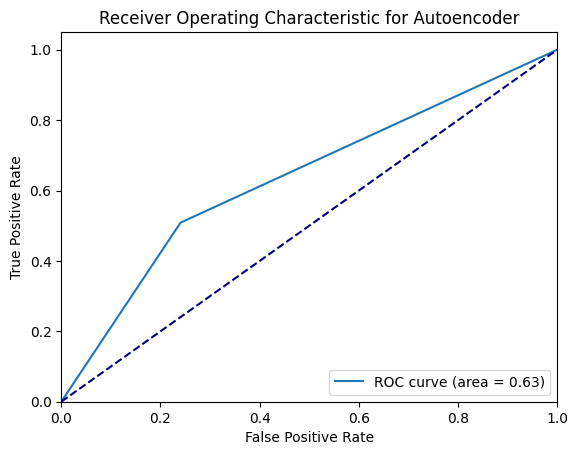

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
print(classification_report(labels, pred_labels))

conf_mat = confusion_matrix(labels, pred_labels)
print('Confusion matrix:\n', conf_mat)

roc_auc = roc_auc_score(labels, pred_labels)
print('ROC AUC Score:', roc_auc)

fpr, tpr, _ = roc_curve(labels, pred_labels)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Autoencoder')
plt.legend(loc="lower right")

plt.savefig('lstmautoencoder_roc_curve_r11n14_integrated.pdf', format='pdf')

plt.show()

In [8]:
print(classification_report(labels, pred_labels))
print(confusion_matrix(labels, pred_labels))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     24550
         1.0       0.93      0.92      0.92     12286

    accuracy                           0.95     36836
   macro avg       0.94      0.94      0.94     36836
weighted avg       0.95      0.95      0.95     36836

[[23658   892]
 [ 1022 11264]]
